# 00 – Detector de itens em diagramas (base Roboflow)

Este notebook cobre a **detecção de itens em diagramas** de arquitetura (AWS/Azure) com YOLO: ícones de serviços, setas, caixas de agrupamento, etc. Não inclui análise STRIDE.

**Dataset:** Roboflow "AWS/Azure System Diagrams" (YOLO, ~4.4k imagens, 203 classes). Obtido com `make download-roboflow` em `dataset/roboflow/`.

## Treinamento fora do notebook

O treinamento YOLO é pesado e **trava o kernel do Jupyter**. Por isso, treinamos via **script em terminal**:

```bash
python -m notebooks.scripts.train.train_yolo --dataset roboflow --epochs 200 --imgsz 416 --batch 2
```

O script `notebooks/scripts/train/train_yolo.py` (ou `make train-roboflow`) suporta `--dataset roboflow` ou `--dataset kaggle`. Os pesos ficam em `outputs/<fonte>/weights/best.pt` e são copiados para `models/<fonte>/best.pt` automaticamente.

## O que este notebook faz

1. **Ambiente e dados** — caminhos, verificação do dataset.
2. **Dataset e classes** — leitura do `data.yaml`, contagem de imagens e labels.
3. **Análise do dataset** — distribuição de classes.
4. **Visualização das anotações** — ground truth com bounding boxes.
5. **Treinamento (referência)** — explicação e comando; o treino real roda no script.
6. **Testes** — inferência em imagens do dataset e em `notebooks/assets/diagram01.png` e `diagram02.png`.

## 1. Ambiente e dados

In [1]:
from pathlib import Path
import yaml
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Raiz do projeto
PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT != PROJECT_ROOT.parent and not (PROJECT_ROOT / "notebooks").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if not (PROJECT_ROOT / "notebooks").exists():
    PROJECT_ROOT = Path.cwd()

NOTEBOOKS_DIR = PROJECT_ROOT / "notebooks"
ASSETS_DIR = NOTEBOOKS_DIR / "assets"

# Estrutura padronizada na raiz: dataset/<fonte>, outputs/<fonte>, models/<fonte>
DATA_DIR = PROJECT_ROOT / "dataset" / "roboflow"
OUTPUTS_DIR = PROJECT_ROOT / "outputs" / "roboflow"
MODELS_DIR = PROJECT_ROOT / "models" / "roboflow"

DATA_YAML = DATA_DIR / "data.yaml"
# Script train_yolo salva em outputs/roboflow/weights/best.pt (ou outputs/roboflow/train/weights/)
TRAIN_WEIGHTS = OUTPUTS_DIR / "weights" / "best.pt"
BEST_MODEL_DEST = MODELS_DIR / "best.pt"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR:", DATA_DIR)
print("OUTPUTS_DIR:", OUTPUTS_DIR)
print("MODELS_DIR:", MODELS_DIR)
print("data.yaml existe:", DATA_YAML.exists())
print("train/images existe:", (DATA_DIR / "train" / "images").exists())

PROJECT_ROOT: /home/lucas-biason/Projetos/Projetos/Ativos/threat-modeling-ai
DATA_DIR: /home/lucas-biason/Projetos/Projetos/Ativos/threat-modeling-ai/dataset/roboflow
OUTPUTS_DIR: /home/lucas-biason/Projetos/Projetos/Ativos/threat-modeling-ai/outputs/roboflow
MODELS_DIR: /home/lucas-biason/Projetos/Projetos/Ativos/threat-modeling-ai/models/roboflow
data.yaml existe: True
train/images existe: True


## 2. Dataset e classes

In [2]:
with open(DATA_YAML) as f:
    data = yaml.safe_load(f)
CLASSES = data.get("names", [])
if isinstance(CLASSES, dict):
    CLASSES = [CLASSES[i] for i in range(len(CLASSES))]
print("Total de classes:", len(CLASSES))
print("Primeiras 15:", CLASSES[:15])
for split in ["train", "valid", "test"]:
    img_dir = DATA_DIR / split / "images"
    lbl_dir = DATA_DIR / split / "labels"
    n_imgs = len(list(img_dir.glob("*.jpg")) + list(img_dir.glob("*.png"))) if img_dir.exists() else 0
    n_lbls = len(list(lbl_dir.glob("*.txt"))) if lbl_dir.exists() else 0
    print(f"  {split}: {n_imgs} imagens, {n_lbls} labels")


Total de classes: 202
Primeiras 15: ['0', '10', '2', '3', '5', '6', '8', '9', 'AAD', 'ACM', 'ALB', 'AMI', 'API-Gateway', 'Active Directory Service', 'Airflow']
  train: 4418 imagens, 4418 labels
  valid: 412 imagens, 412 labels
  test: 223 imagens, 223 labels


## 3. Análise do dataset

Antes de treinar, é útil **entender a distribuição das classes** nas anotações. Um dataset **desbalanceado** (poucas amostras em algumas classes e muitas em outras) pode fazer o modelo **tender a prever só as classes mais frequentes** (por exemplo **"groups"**).

Abaixo fazemos:
- **Contagem por split** — quantos arquivos e anotações em train/valid/test.
- **Top 20 classes** — as mais frequentes e sua porcentagem do total.
- **Classes raras** — com menos de 10 amostras (podem ser mal aprendidas).
- **Classe "groups"** — proporção no dataset; se for muito alta (>20%), o modelo pode ficar enviesado para essa classe.
- **Desbalanceamento** — razão entre a classe mais e a menos frequente; ratio alto sugere uso de pesos por classe ou mais augmentação.

In [3]:
from collections import Counter

def _count_classes_in_labels(labels_path):
    """Conta ocorrências de cada classe nos arquivos .txt do split."""
    cnt = Counter()
    if not labels_path.exists():
        return cnt
    for f in labels_path.glob("*.txt"):
        with open(f) as fp:
            for line in fp:
                parts = line.strip().split()
                if parts:
                    try:
                        cnt[int(parts[0])] += 1
                    except ValueError:
                        pass
    return cnt

class_names = CLASSES  # já carregado na célula anterior
splits = ["train", "valid", "test"]
all_counts = Counter()

for split in splits:
    lbl_path = DATA_DIR / split / "labels"
    counts = _count_classes_in_labels(lbl_path)
    all_counts.update(counts)
    n_files = len(list(lbl_path.glob("*.txt"))) if lbl_path.exists() else 0
    n_ann = sum(counts.values())
    print(f"\n{split.upper()}: {n_files} arquivos, {n_ann} anotações")

total_ann = sum(all_counts.values())
n_with_samples = sum(1 for c in all_counts.values() if c > 0)
print(f"\n{'='*60}")
print(f"Total de anotações: {total_ann}")
print(f"Classes com amostras: {n_with_samples}/{len(class_names)}")

print(f"\nTop 20 classes mais frequentes:")
print(f"{'Rank':<5} {'ID':<5} {'Nome':<35} {'Count':<8} {'%':<8}")
print("-" * 65)
for rank, (cid, count) in enumerate(all_counts.most_common(20), 1):
    name = class_names[cid] if cid < len(class_names) else f"ID_{cid}"
    pct = (count / total_ann * 100) if total_ann else 0
    print(f"{rank:<5} {cid:<5} {str(name):<35} {count:<8} {pct:.2f}%")

MIN_SAMPLES = 10
rare = [(c, n) for c, n in all_counts.items() if n < MIN_SAMPLES]
print(f"\nClasses com menos de {MIN_SAMPLES} amostras: {len(rare)}")
if rare:
    for cid, count in sorted(rare, key=lambda x: x[1]):
        name = class_names[cid] if cid < len(class_names) else f"ID_{cid}"
        print(f"  {cid:<5} {str(name):<35} {count:<8}")

groups_id = next((i for i, n in enumerate(class_names) if str(n).lower() == "groups"), None)
if groups_id is not None:
    g_count = all_counts.get(groups_id, 0)
    g_pct = (g_count / total_ann * 100) if total_ann else 0
    print(f"\nClasse 'groups' (ID {groups_id}): {g_count} anotações ({g_pct:.2f}%)")
    if g_pct > 20:
        print("  Alerta: proporção alta pode causar viés no modelo (previsões dominadas por groups).")

if all_counts:
    mx, mn = max(all_counts.values()), min(all_counts.values())
    ratio = mx / mn if mn > 0 else float("inf")
    print(f"\nDesbalanceamento: classe max={mx}, min={mn}, ratio={ratio:.1f}x")
    if ratio > 100:
        print("  Alerta: desbalanceamento severo. Considere class weights ou agrupar classes raras.")
    elif ratio > 20:
        print("  Desbalanceamento moderado. Aumentar data augmentation pode ajudar.")
print("\n" + "="*60)


TRAIN: 4418 arquivos, 8995 anotações

VALID: 412 arquivos, 490 anotações

TEST: 223 arquivos, 573 anotações

Total de anotações: 10058
Classes com amostras: 203/202

Top 20 classes mais frequentes:
Rank  ID    Nome                                Count    %       
-----------------------------------------------------------------
1     202   ID_202                              609      6.05%
2     26    Azure                               544      5.41%
3     196   Web App                             541      5.38%
4     118   Lambda                              530      5.27%
5     138   PostgreSQL                          481      4.78%
6     8     AAD                                 448      4.45%
7     91    Firewall                            448      4.45%
8     194   Vm Scaleset                         420      4.18%
9     27    Azure monitor                       417      4.15%
10    90    File share                          354      3.52%
11    153   S3                         

## 4. Visualização das anotações

uma imagem com bounding boxes (ground truth).

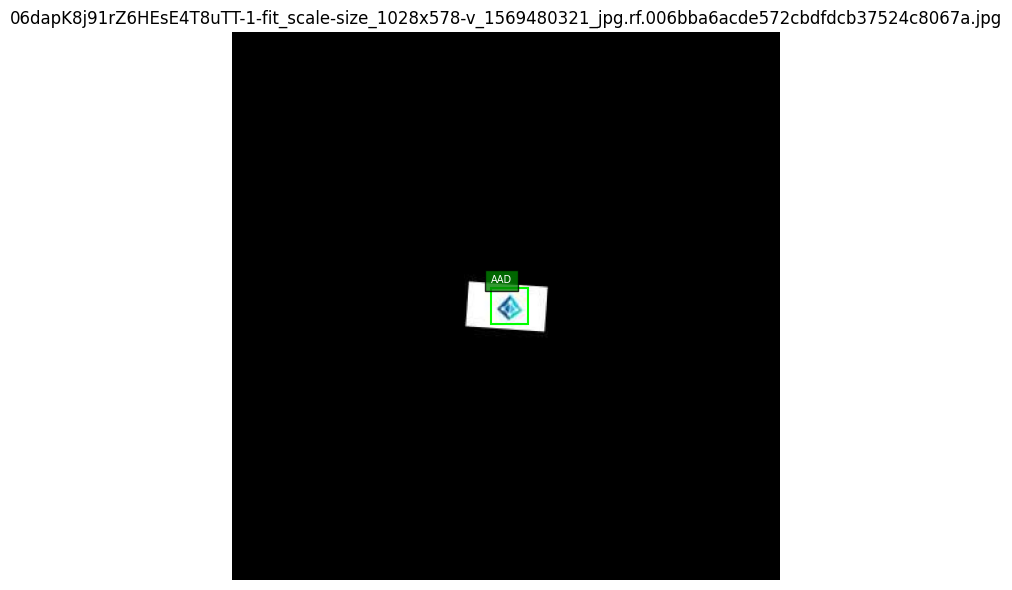

In [4]:
train_img = DATA_DIR / "train" / "images"
train_lbl = DATA_DIR / "train" / "labels"
imagens = sorted(list(train_img.glob("*.jpg")) + list(train_img.glob("*.png")))[:1] if train_img.exists() else []

if not imagens:
    print("Nenhuma imagem em train/images.")
else:
    img_path = imagens[0]
    lbl_path = train_lbl / (img_path.stem + ".txt")
    img = np.array(Image.open(img_path).convert("RGB"))
    h, w = img.shape[:2]
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.imshow(img)
    if lbl_path.exists():
        with open(lbl_path) as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    cid = int(parts[0])
                    xc, yc, bw, bh = map(float, parts[1:5])
                    x1 = int((xc - bw/2) * w)
                    y1 = int((yc - bh/2) * h)
                    x2 = int((xc + bw/2) * w)
                    y2 = int((yc + bh/2) * h)
                    nome = CLASSES[cid] if cid < len(CLASSES) else str(cid)
                    ax.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor="lime", lw=1.5))
                    ax.text(x1, y1-4, nome, color="white", fontsize=7, bbox=dict(facecolor="green", alpha=0.8))
    ax.set_title(img_path.name)
    ax.axis("off")
    plt.tight_layout()
    plt.show()

## 5. Treinamento do modelo (executar via script)

O treinamento YOLO consome muita memória e **trava o kernel do Jupyter**. Use o script `notebooks/scripts/train/train_yolo.py` (ou `make train-roboflow`) no terminal.

**Comando para Roboflow:**
```bash
python -m notebooks.scripts.train.train_yolo --dataset roboflow --epochs 200 --imgsz 416 --batch 2
```

**O script:** Carrega YOLOv11n, treina no `data.yaml` de `dataset/roboflow/`, salva em `outputs/roboflow/weights/best.pt` e copia para `models/roboflow/best.pt`. Use `--device 0` para GPU.

In [5]:
# Treinamento: execute no terminal, não aqui (trava o kernel)
print('Execute no terminal:')
print('  python -m notebooks.scripts.train.train_yolo --dataset roboflow --epochs 200 --imgsz 416 --batch 2')
print('Após o treino, o modelo estará em outputs/roboflow/weights/best.pt e models/roboflow/best.pt')

Execute no terminal:
  python -m notebooks.scripts.train.train_yolo --dataset roboflow --epochs 200 --imgsz 416 --batch 2
Após o treino, o modelo estará em outputs/roboflow/weights/best.pt e models/roboflow/best.pt


## 6. Curvas de loss (métricas do treino)

Se o treino foi executado via script, o Ultralytics gera `outputs/roboflow/results.csv`. Aqui plotamos as curvas de loss para inspecionar a convergência.

In [6]:
import pandas as pd

results_csv = OUTPUTS_DIR / "results.csv"
if not results_csv.exists():
    results_csv = OUTPUTS_DIR / "train" / "results.csv"
if results_csv.exists():
    df = pd.read_csv(results_csv)
    df.columns = df.columns.str.strip()
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    if "train/box_loss" in df.columns:
        ax.plot(df["train/box_loss"], label="box_loss")
    if "train/cls_loss" in df.columns:
        ax.plot(df["train/cls_loss"], label="cls_loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.set_title("Curvas de loss (treino)")
    plt.tight_layout()
    plt.show()
else:
    print("results.csv não encontrado. Execute o script de treino e verifique outputs/roboflow/.")

results.csv não encontrado. Execute o script de treino e verifique outputs/roboflow/.


## 7. Carregar modelo e testar em imagens do dataset

Carregamos o `best.pt` e rodamos inferência. Para diagramas: **conf=0.15** (detecta mais ícones), **excluir_classes=("groups",)** (evita poluição visual; grupos são caixas de agrupamento). Mostra apenas componentes úteis: EC2, S3, API Gateway, etc.

In [7]:
# Onde procurar o modelo (ordem de preferência)
candidatos = [TRAIN_WEIGHTS, BEST_MODEL_DEST, OUTPUTS_DIR / "weights" / "best.pt", OUTPUTS_DIR / "train" / "weights" / "best.pt"]
weights_path = next((p for p in candidatos if p.exists()), None)

if weights_path is None:
    raise FileNotFoundError(
        "Nenhum best.pt encontrado. Rode a célula de treino ou coloque best.pt em "
        "outputs/roboflow/weights/ ou models/roboflow/"
    )

model = YOLO(str(weights_path))
print("Modelo carregado:", weights_path)
print("Classes no modelo:", len(model.names))

Modelo carregado: /home/lucas-biason/Projetos/Projetos/Ativos/threat-modeling-ai/models/roboflow/best.pt
Classes no modelo: 203


In [8]:
def run_detection_and_plot(model, image_path, conf=0.15, iou=0.45, title=None, excluir_classes=("groups",)):
    """Roda detecção e exibe imagem. Por padrão exclui 'groups' para focar em componentes reais (EC2, S3, etc).
    conf mais baixo (0.15) ajuda a detectar ícones que o modelo prevê com confiança menor."""
    image_path = Path(image_path)
    if not image_path.exists():
        print("Arquivo não encontrado:", image_path)
        return []
    results = model(str(image_path), conf=conf, iou=iou, verbose=False)
    excluir_padrao = set(["groups", "group", "Groups", "Group"]); excluir = set(excluir_classes) if excluir_classes else excluir_padrao
    detections = []
    componentes_unicos = set()
    for r in results:
        if r.boxes is None:
            continue
        for box in r.boxes:
            cls_id = int(box.cls[0])
            c = float(box.conf[0])
            nome_classe = model.names[cls_id]
            if nome_classe in excluir:
                continue
            componentes_unicos.add(nome_classe)
            detections.append({
                "class": nome_classe,
                "confidence": c,
                "box": box.xyxy[0].tolist()
            })
    img = np.array(Image.open(image_path).convert("RGB"))
    fig, ax = plt.subplots(1, 1, figsize=(14, 9))
    ax.imshow(img)
    for d in detections:
        x1, y1, x2, y2 = d["box"]
        ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor="lime", lw=2))
        ax.text(x1, y1 - 5, f"{d['class']} {d['confidence']:.2f}", color="white", fontsize=8,
                bbox=dict(facecolor="green", alpha=0.7))
    ax.set_title(title or f"{image_path.name} - {len(detections)} detecções, {len(componentes_unicos)} classes")
    ax.axis("off")
    plt.tight_layout()
    plt.show()
    return detections

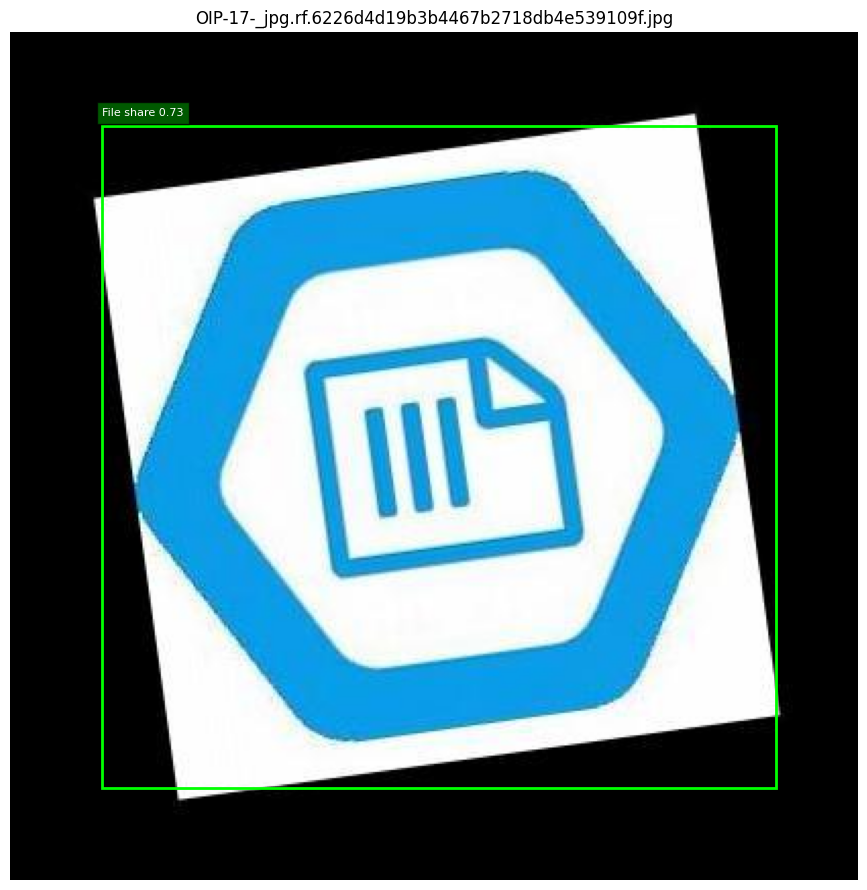

  OIP-17-_jpg.rf.6226d4d19b3b4467b2718db4e539109f.jpg: 1 detecções


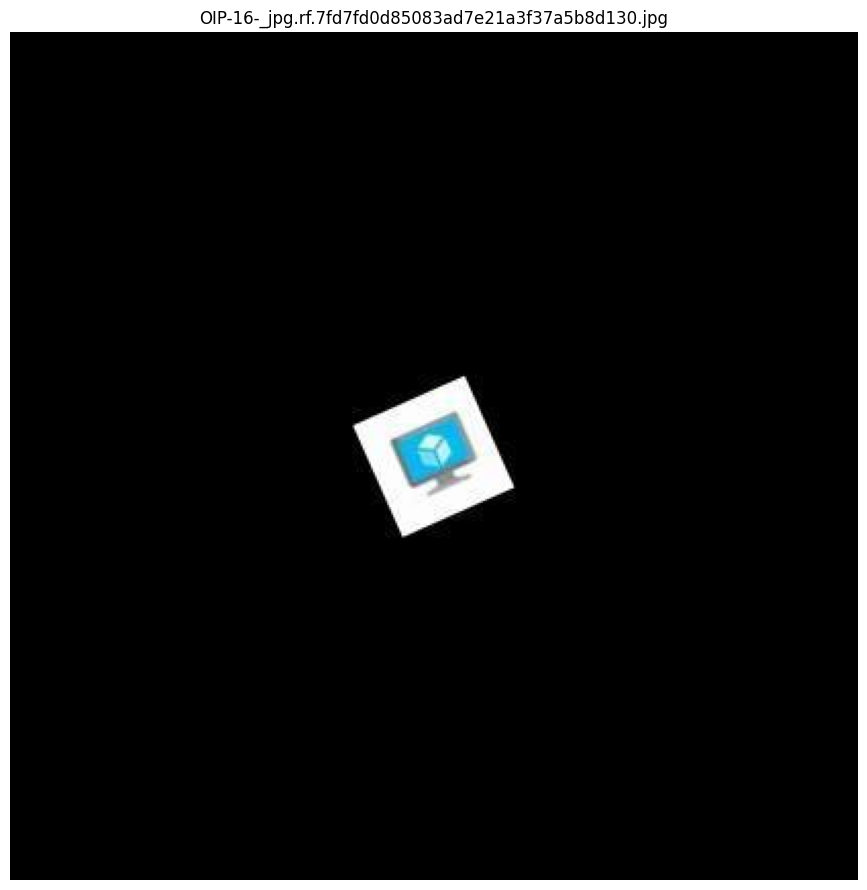

  OIP-16-_jpg.rf.7fd7fd0d85083ad7e21a3f37a5b8d130.jpg: 0 detecções


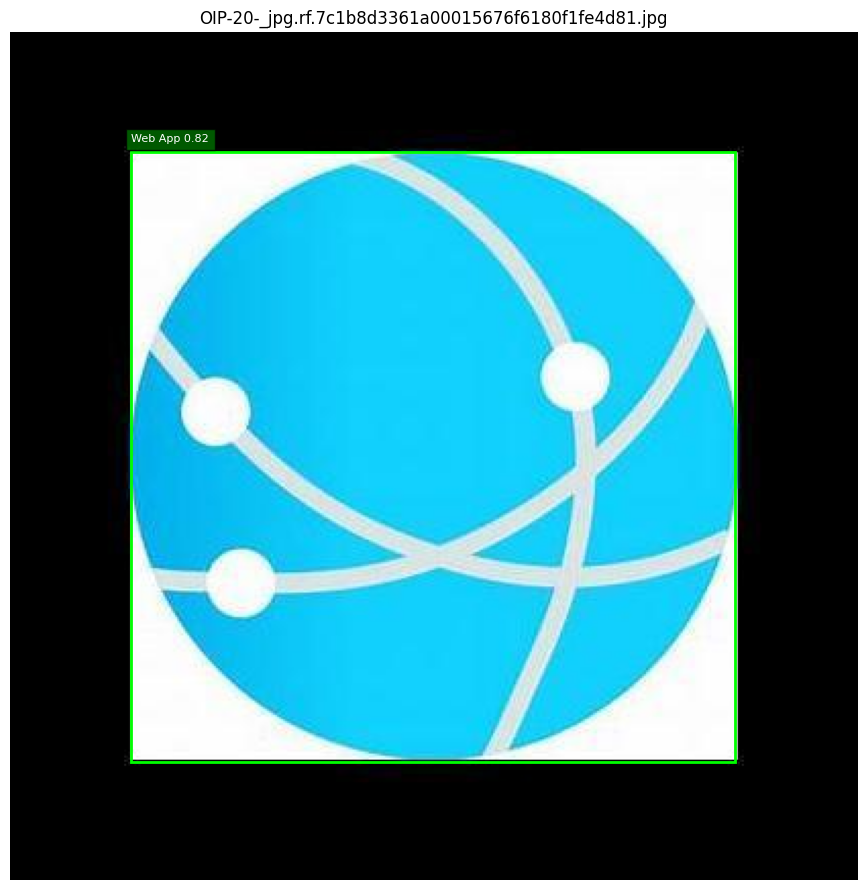

  OIP-20-_jpg.rf.7c1b8d3361a00015676f6180f1fe4d81.jpg: 1 detecções


In [9]:
# Testar em algumas imagens do dataset (train ou valid)
train_img = DATA_DIR / "train" / "images"
valid_img = DATA_DIR / "valid" / "images"
sample_dirs = [train_img, valid_img] if (valid_img.exists() and list(valid_img.glob("*"))) else [train_img]
all_imgs = []
for d in sample_dirs:
    if d.exists():
        all_imgs.extend(list(d.glob("*.jpg")) + list(d.glob("*.png")))
import random
random.seed(42)
n_test = min(3, len(all_imgs))
test_imgs = random.sample(all_imgs, n_test) if all_imgs else []

if not test_imgs:
    print("Nenhuma imagem encontrada em train/images ou valid/images.")
else:
    for path in test_imgs:
        dets = run_detection_and_plot(model, path, conf=0.35, iou=0.45, title=path.name)
        print(f"  {path.name}: {len(dets)} detecções")

## 8. Testes nos diagramas (assets)

Rodamos o modelo nas imagens **diagram01.png** e **diagram02.png** em `notebooks/assets/` para avaliar a detecção em diagramas reais (AWS e Azure).

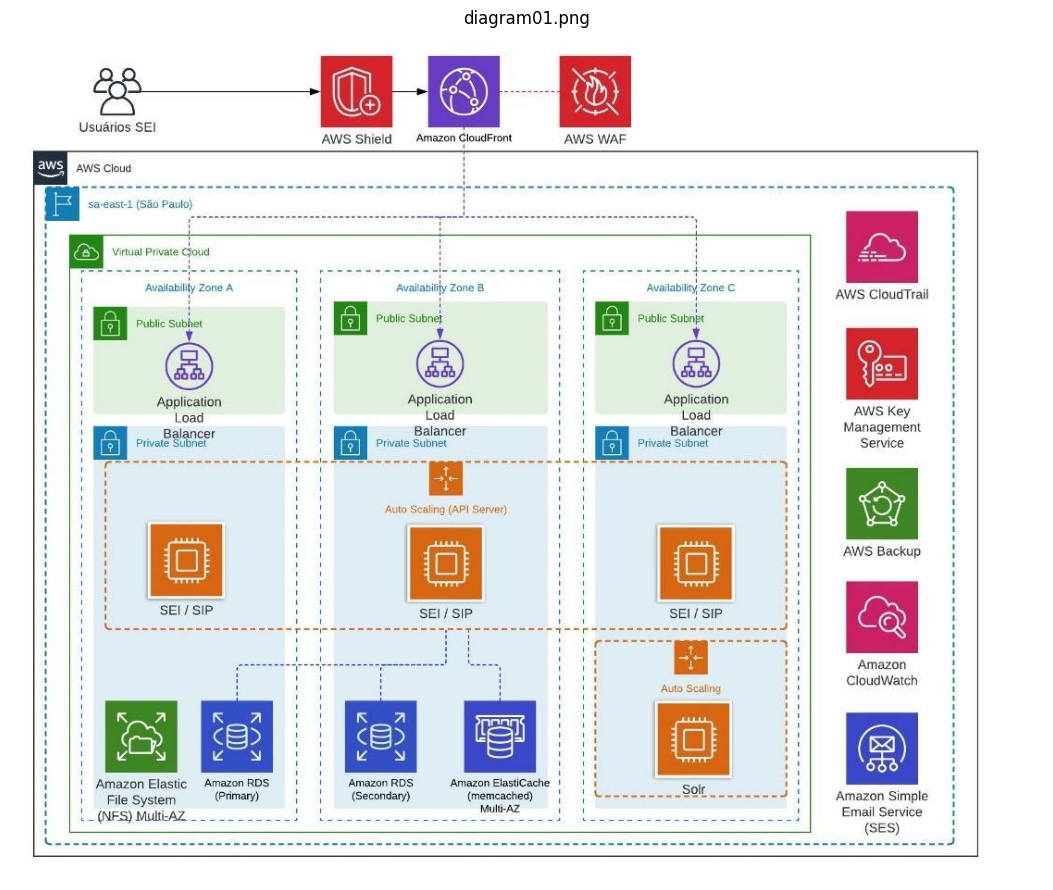

  diagram01.png: 0 detecções


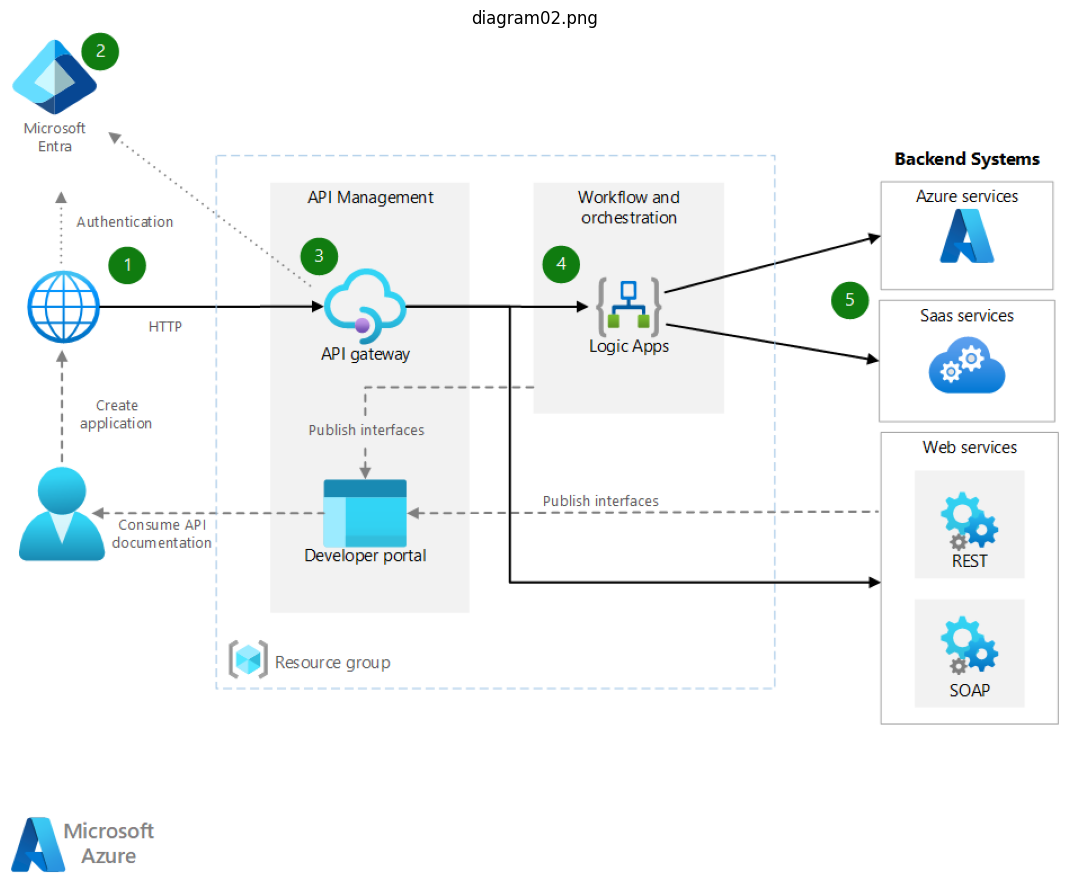

  diagram02.png: 0 detecções


In [10]:
# Testes em diagram01.png e diagram02.png (igual ao sistema de referência)
for name in ["diagram01.png", "diagram02.png"]:
    path = ASSETS_DIR / name
    if path.exists():
        dets = run_detection_and_plot(model, path, conf=0.35, iou=0.45, title=name)
        print(f"  {name}: {len(dets)} detecções")
    else:
        print(f"  {name}: arquivo não encontrado em {ASSETS_DIR}")